# Basic statistics and visualization

In [1]:
import admix
import numpy as np
import dapgen
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# read the simulated dataset
admix.dataset.download_simulated_example_data()
dset = admix.io.read_dataset("example_data/CEU-YRI")

2024-02-07 16:27:53 [info     ] Example data set already exists at .//example_data, skip downloading


## Local ancestry

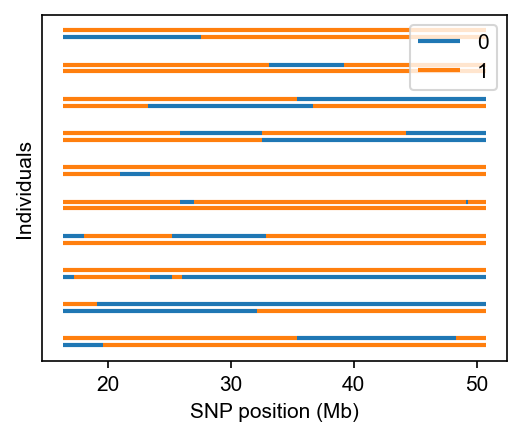

In [3]:
# plot local ancestries for the first 10 individuals
fig, ax = plt.subplots(figsize=(4, 3), dpi=150)
admix.plot.lanc(dset=dset, max_indiv=10)
plt.show()

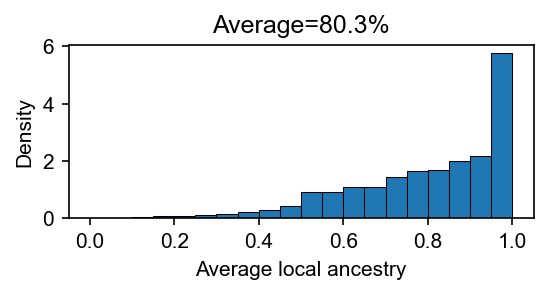

In [4]:
# plot the average local ancestry per-person
lanc = dset.lanc.compute()
avg_lanc = lanc.mean(axis=(0, 2))
fig, ax = plt.subplots(figsize=(4, 1.5), dpi=150)
ax.hist(avg_lanc, bins=20, edgecolor="black", linewidth=0.5, density=True)
ax.set_xlabel("Average local ancestry")
ax.set_ylabel("Density")
ax.set_title(f"Average={avg_lanc.mean() * 100:.1f}%")
plt.show()

## Global ancestry
We first merge the simulated dataset with 1,000 Genomes reference data.

```bash
# joint PCA with 1kg
ref_pfile=example_data/1kg-ref    # path to 1kg pgen file (all chromosomes)
out_dir=example_data/joint-pca    # path to output directory

mkdir -p ${out_dir}

plink2 --pfile ${ref_pfile} \
       --freq counts \
       --pca allele-wts \
       --out ${out_dir}/ref_pcs

for name in 1kg-ref CEU-YRI; do
    plink2 --pfile example_data/${name} \
       --read-freq ${out_dir}/ref_pcs.acount \
       --score ${out_dir}/ref_pcs.eigenvec.allele 2 5 header-read no-mean-imputation \
               variance-standardize \
       --score-col-nums 6-15 \
       --out ${out_dir}/${name}
done
```

Then we plot the PCA with 1,000 Genomes reference and the simulated dataset.

Text(0.5, 1.0, '1kg reference + simulated')

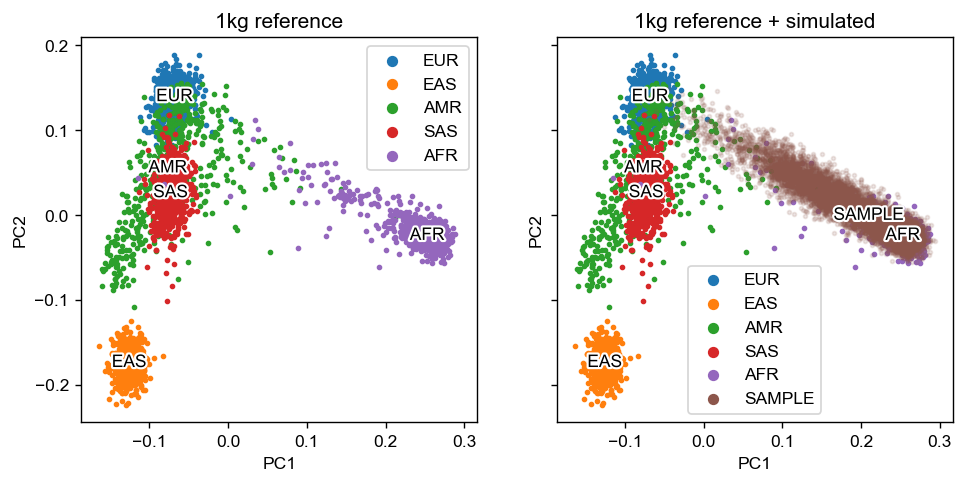

In [5]:
pca_dir = "example_data/joint-pca"

pca_df = pd.read_csv(f"{pca_dir}/1kg-ref.sscore", sep='\t', index_col=0).rename(columns = {f"PC{i}_AVG": f"PC{i}" for i in range(1, 11)})
sample_df = pd.read_csv(f"{pca_dir}/CEU-YRI.sscore", sep='\t', index_col=0).rename(columns = {f"PC{i}_AVG": f"PC{i}" for i in range(1, 11)})

sample_df['SuperPop'] = "SAMPLE"
pca_df = pd.concat([pca_df, sample_df], axis=0)

fig, axes = plt.subplots(figsize=(9, 4), dpi=125, ncols=2, sharex=True, sharey=True)

admix.plot.joint_pca(
    df_pc=pca_df,
    axes=axes,
    x="PC1",
    y="PC2",
    sample_alpha=0.15,
    label_col="SuperPop"
)
axes[0].set_title("1kg reference")
axes[1].set_title("1kg reference + simulated")

admix.data.af_per_anc: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:12<00:00,  1.16it/s]


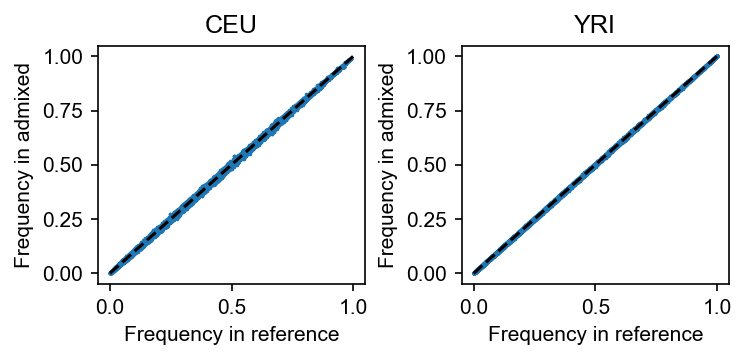

In [6]:
geno, snp_df, indiv_df = dapgen.read_plink("example_data/1kg-ref.pgen")

# sanity check for the consistency of frequency calculated in the reference data sets
# and the frequency calculated in the admixed data set
fig, axes = plt.subplots(figsize=(5, 2.5), dpi=150, ncols=2)
for i, anc in enumerate(["CEU", "YRI"]):
    axes[i].scatter(
        geno[:, indiv_df.Population == anc].mean(axis=1) / 2, dset.af_per_anc()[:, i], s=0.5
    )
    axes[i].set_title(anc)
    axes[i].set_xlabel("Frequency in reference")
    axes[i].set_ylabel("Frequency in admixed")
    axes[i].plot([0, 1], [0, 1], "k--")

fig.tight_layout()